In [8]:
import pandas as pd

dataset_analysis = pd.read_csv('full_timeperiod.csv')


dataset_analysis = dataset_analysis.loc[dataset_analysis['phases4'] != '0']
df = dataset_analysis[['elev', 'GDD', 'GDD_90', 
                 'CDD', 'CDD_90', 'rainfall_90', 'dayl..s.',
       'rainfall_120', 'FD', 'HD', 'HRD', 'avg_rainfall', 'semi_arid',
       'FDxElev',  'srad_60_shift_30', 'srad_30', 
       'HDxrain', 'vpd_30', 'vpd_60_shift_30', 'lat', 'lon']]

df_y = dataset_analysis[['phases4', 'elev', 'GDD', 'GDD_90', 
                 'CDD', 'CDD_90', 'rainfall_90', 'dayl..s.',
       'rainfall_120', 'FD', 'HD', 'HRD', 'avg_rainfall', 'semi_arid',
       'FDxElev',  'srad_60_shift_30', 'srad_30', 
       'HDxrain', 'vpd_30', 'vpd_60_shift_30', 'lat', 'lon']]


df = df.dropna()
df_y = df_y.dropna()
df_y = df_y[['phases4']]
print(df.count())
print(df_y.count())

elev                207688
GDD                 207688
GDD_90              207688
CDD                 207688
CDD_90              207688
rainfall_90         207688
dayl..s.            207688
rainfall_120        207688
FD                  207688
HD                  207688
HRD                 207688
avg_rainfall        207688
semi_arid           207688
FDxElev             207688
srad_60_shift_30    207688
srad_30             207688
HDxrain             207688
vpd_30              207688
vpd_60_shift_30     207688
lat                 207688
lon                 207688
dtype: int64
phases4    207688
dtype: int64


In [9]:
%matplotlib inline
import pandas as pd # for using pandas daraframe
import numpy as np # for som math operations
from sklearn.preprocessing import StandardScaler # for standardizing the Data
from sklearn.decomposition import PCA # for PCA calculation
import matplotlib.pyplot as plt # for plotting
import plotly.graph_objects as go
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [10]:
X = df.values # getting all values as a matrix of dataframe 
y = df_y.values
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data
y

array([['rising'],
       ['rising'],
       ['rising'],
       ...,
       ['dormant'],
       ['dormant'],
       ['dormant']], dtype=object)

In [11]:
 ##Load and split data

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y.astype(str), test_size=0.25, random_state=0)
y_train = y_train.ravel()
y_test = y_test.ravel()


In [12]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
ys = clf.predict(X_test)

In [13]:
y_scoredf = pd.DataFrame(ys)
y_scoredf['actuals'] = y_test
summary = y_scoredf.value_counts().unstack()

summary

actuals,dormant,falling,fullgreen,rising
0,,,,
dormant,24997.0,186.0,13.0,131.0
falling,164.0,2448.0,172.0,NaN
fullgreen,16.0,181.0,21585.0,148.0
rising,133.0,NaN,134.0,1614.0


In [14]:
summary.apply(lambda x: x/x.sum(), axis=1)

actuals,dormant,falling,fullgreen,rising
0,,,,
dormant,0.986970,0.007344,0.000513,0.005172
falling,0.058908,0.879310,0.061782,NaN
fullgreen,0.000730,0.008254,0.984268,0.006749
rising,0.070707,NaN,0.071239,0.858054


In [19]:
from sklearn.inspection import permutation_importance

import time

feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names =['elev', 'GDD', 'GDD_90', 
                 'CDD', 'CDD_90', 'rainfall_90', 'dayl..s.',
       'rainfall_120', 'FD', 'HD', 'HRD', 'avg_rainfall', 'semi_arid',
       'FDxElev',  'srad_60_shift_30', 'srad_30', 
       'HDxrain', 'vpd_30', 'vpd_60_shift_30', 'lat', 'lon']


In [20]:
start_time = time.time()
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 2.152 seconds


In [34]:
clf = tree.DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

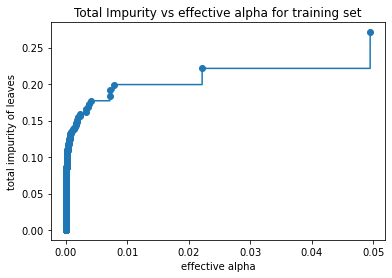

In [35]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [37]:
ccp_alphas = np.where(ccp_alphas <= 0, 0.0001, ccp_alphas)
print(ccp_alphas)

[1.00000000e-04 1.00000000e-04 1.00000000e-04 ... 2.21792822e-02
 4.95123272e-02 3.10510401e-01]


In [38]:
ccp_alphas.shape

(2290,)

In [39]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3105104005913908


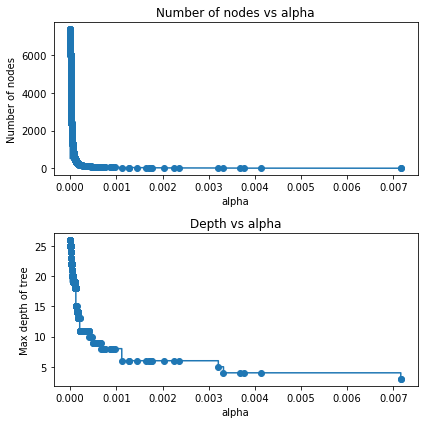

In [55]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("Max depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

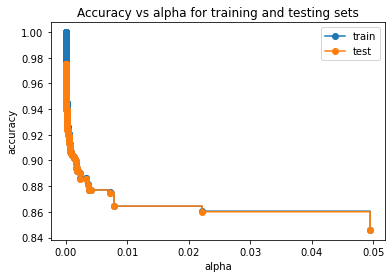

In [41]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
# ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
# ax.legend()
# plt.show()

In [50]:
len(depth), len(train_scores), len(test_scores)

(2289, 2289, 2289)

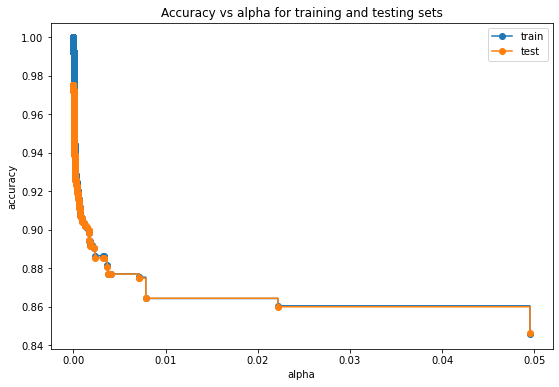

In [52]:
fig, ax = plt.subplots( figsize=(9, 6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

In [25]:
df.columns[[6, 2, 17, 14]]
# df.columns

Index(['dayl..s.', 'GDD_90', 'vpd_30', 'srad_60_shift_30'], dtype='object')

In [56]:
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
)
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree

clf_ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))

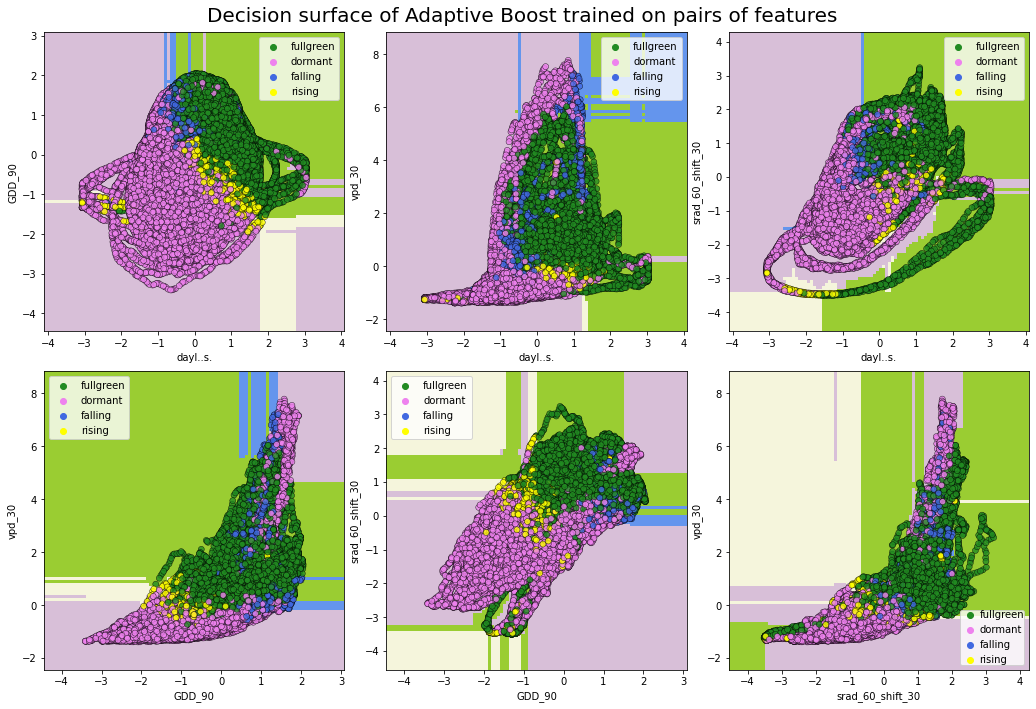

In [58]:
cmap_light = ListedColormap(["thistle", "cornflowerblue", "yellowgreen", "beige"])
cmap_bold = ["forestgreen", "violet", "royalblue", "yellow"]

n_neighbors = 15

plt.subplots(2, 3, figsize=(15, 10))

for pairidx, pair in enumerate([[6, 2], [6, 17], [6, 14], [2, 17], [2, 14], [14, 17]]):
    # We only take the two corresponding features
    X = X_train[:, pair]
    y = y_train

# for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
#     clf = neighbors.KNeighborsClassifier(n_neighbors) #, weights=weights)
    clf_ab.fit(X, y)
    
    ax = plt.subplot(2, 3, pairidx + 1)

    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)   
    
    DecisionBoundaryDisplay.from_estimator(
        clf_ab,
        X,
        cmap = cmap_light,
        ax = ax,
        response_method = "predict",
        plot_method = "pcolormesh",
        xlabel = df.columns[pair[0]],
        ylabel = df.columns[pair[1]],
        shading = "auto",
    )

    # Plot also the training points
    sns.scatterplot(
        x = X[:, 0],
        y = X[:, 1],
        hue = y,
        palette = cmap_bold,
        alpha = .8,
        edgecolor = "black",
    )

plt.suptitle("Decision surface of Adaptive Boost trained on pairs of features", fontsize = 20, y = 1)

plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")
plt.show()